# Rough code used for training scripts

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import plotly.express as px
import plotly.graph_objects as go
import itertools
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from diffusers import DDPMScheduler
import matplotlib.pyplot as plt

import sys
sys.path.insert(1,"../scripts")
from get_voxels import get_mol_voxels
from networks import Encoder, UNet3D, AutoEncoder, UNet3D_cond

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

encoder = Encoder()
# encoder = AutoEncoder()
encoder.to(device)

# encoder.load_state_dict(torch.load("../models/state_dict_encoder.pt"))
encoder.load_state_dict(torch.load("../models/state_dict_autoencoder.pt"))

Using device: cuda


<All keys matched successfully>

## Get list of smiles

In [2]:
smiles = []
with open("../datasets/raw/zinc15_druglike_clean_canonical_max60.smi") as f:
    i=0
    for i, line in enumerate(f):
        smiles.append(line)
        if i > 5000000:
            break

# smiles = smiles[528000:]

In [4]:
smiles[746443]

'COC(=O)CN(C)C(=O)c1cccnc1Cl\n'

## Set up custom dataloader with vox encoding

Collate_bach generates vox representations on the fly, prevent kernel crash due to being out of memory

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, smiles):
        self.transform = get_mol_voxels
        self.smiles = smiles

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        return smile

smile_DS = CustomImageDataset(smiles)

def collate_batch(smiles):
    inputs = []
    target = []
    for smile in smiles:
        try:
            rep, pharm = get_mol_voxels(smile)
            inputs.append(rep)
            target.append(pharm)
        except:
            continue

    return torch.stack(inputs), torch.stack(target)

Train Encoder

In [7]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(smile_DS, batch_size=128, collate_fn=collate_batch)

# How many runs through the data should we do?
n_epochs = 1

# Our loss finction
criterion = nn.MSELoss()
# The optimizer
optimizer = torch.optim.Adam(encoder.parameters())

# Keeping a record of the losses for later viewing
losses_enc = []

In [8]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        x = x.to(device)
        targets = targets.to(device)

        # Forward pass
        encoded_tensor = encoder(x)
        loss = criterion(encoded_tensor, targets)
        losses_enc.append(loss.cpu().detach().numpy())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%100 == 0:
            torch.save(encoder.state_dict(), "../models/state_dict_autoencoder.pt")
            print(loss.cpu().detach().numpy())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_enc[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average enc loss for this epoch: {avg_loss:05f}')#

0.00072839693
Gen_rep_fails
0.0007637875
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails


[10:51:19] UFFTYPER: Unrecognized atom type: S_5+4 (1)


0.00086396246
0.00064848375
0.00090032915
0.00064846367
0.0007948377
0.0007540997
0.0007151723
0.0006437302
Gen_rep_fails
Gen_rep_fails
0.00071338355
0.000825355
0.0006731478
Gen_rep_fails
Gen_rep_fails


## Train the unet

Ideally would train both at the same time, but memory becomes an issue - running on a laptop with only 4GB gpu ram

In [ ]:
net = UNet3D(in_channels=5, num_classes=5)
net.to(device)

net.load_state_dict(torch.load("../models/state_dict_net.pt"))

<All keys matched successfully>

In [ ]:
# How many runs through the data should we do?
n_epochs = 1

train_dataloader = DataLoader(smile_DS, batch_size=32, collate_fn=collate_batch)

# Our loss finction
loss_fn = nn.BCELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=0.001) 

# Keeping a record of the losses for later viewing
losses_net = []
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        timesteps = torch.randint(
            0,
            ddpm.num_train_timesteps,
            (x.shape[0],),
            device=x.device,
        ).long()

        noise = torch.randn(x.shape).to(x.device)
        noisy_x = ddpm.add_noise(x, noise, timesteps)


        noisy_x = noisy_x.type(torch.FloatTensor).to(device)

        x = x.to(device) # Data on the GPU
        # Get the model prediction

        pred = net(noisy_x)

        # Calculate the loss
        
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        losses_net.append(loss.cpu().detach().numpy())

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i%500 == 0:
            torch.save(net.state_dict(), "../models/state_dict_net.pt")
            print("500 batches done")


    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_net[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses_net)

500 batches done
500 batches done
500 batches done
500 batches done
Gen_rep_fails
500 batches done
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
500 batches done
Gen_rep_fails


Timestep Conditioning

In [7]:
from networks import UNet3D_tcond

net = UNet3D_tcond(in_channels=5, num_classes=5)
net.to(device)

net.load_state_dict(torch.load("../models/state_dict_net_tcond.pt"))

<All keys matched successfully>

In [9]:
# How many runs through the data should we do?
n_epochs = 1

train_dataloader = DataLoader(smile_DS, batch_size=32, collate_fn=collate_batch)

# Our loss finction
loss_fn = nn.BCELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=0.001) 

# Keeping a record of the losses for later viewing
losses_net = []
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
500 batches done
tensor(0.0162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
ten

[09:15:14] UFFTYPER: Unrecognized atom type: S_5+4 (1)


tensor(0.0151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
500 batches done
tensor(0.0132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
ten

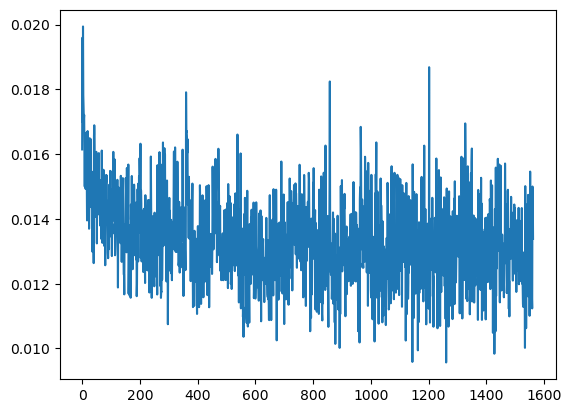

In [ ]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        timesteps = torch.randint(
            0,
            ddpm.num_train_timesteps,
            (x.shape[0],),
            device=x.device,
        ).long()

        noise = torch.randn(x.shape).to(x.device)
        noisy_x = ddpm.add_noise(x, noise, timesteps)


        noisy_x = noisy_x.type(torch.FloatTensor).to(device)

        x = x.to(device) # Data on the GPU
        # Get the model prediction

        pred = net(noisy_x, timesteps.to(device))

        # Calculate the loss
        
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        losses_net.append(loss.cpu().detach().numpy())

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i%10 == 0:
            print(loss)

        if i%500 == 0:
            torch.save(net.state_dict(), "../models/state_dict_net_tcond.pt")
            print("500 batches done")


    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_net[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses_net)

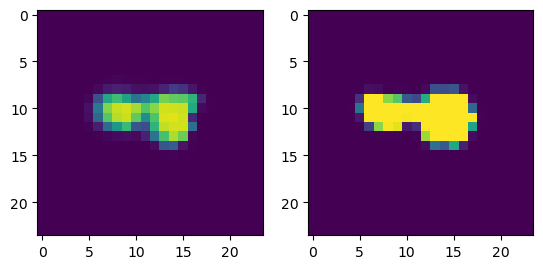

In [34]:
rep, pharm = get_mol_voxels("OC(C=C1)=C(CN2CCCC2)C=C1NC3=CC=NC4=CC=CC=C43")

noise = torch.randn(1,5,24,24,24)
timestep = torch.tensor([50])
noisy_rep = ddpm.add_noise(rep.reshape(-1,5,24,24,24),noise, timestep)
out = net(noisy_rep.cuda(),timestep.cuda()).cpu().detach().numpy()
# out = net(noise.cuda(),pharm.reshape(-1,3,24,24,24).cuda()).cpu().detach().numpy()

chan = 1
layer = 12
fig, axs = plt.subplots(1,2)
axs[0].imshow(out[0][chan][layer], vmin=0,vmax=1)
axs[1].imshow(rep[chan][layer], vmin=0, vmax=1)

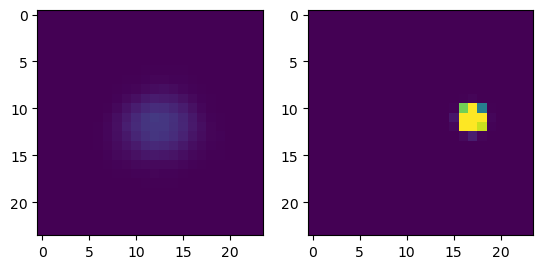

In [87]:
x = torch.randn(1,5,24,24,24).to(device)

ddpm.set_timesteps(50)

# Sampling loop
for i, t in enumerate(ddpm.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t.expand(1).to(device))  # Again, note that we pass in our labels y

    # Update sample with step
    x = ddpm.step(residual, t, x).prev_sample

# Show the results
out = residual.cpu().detach().numpy()

chan = 2
layer = 12
fig, axs = plt.subplots(1,2)
axs[0].imshow(out[0][chan][layer], vmin=0,vmax=1)
axs[1].imshow(rep[chan][layer], vmin=0, vmax=1)

Pharmacophore Conditioning

In [ ]:
from networks import UNet3D_cond

net = UNet3D_cond(in_channels=5, num_classes=5)
net.to(device)

net.load_state_dict(torch.load("../models/state_dict_net_tcond.pt"))

<All keys matched successfully>

In [ ]:
# How many runs through the data should we do?
n_epochs = 1

train_dataloader = DataLoader(smile_DS, batch_size=32, collate_fn=collate_batch)

# Our loss finction
loss_fn = nn.BCELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=0.001) 

# Keeping a record of the losses for later viewing
losses_net = []
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        timesteps = torch.randint(
            0,
            ddpm.num_train_timesteps,
            (x.shape[0],),
            device=x.device,
        ).long()

        noise = torch.randn(x.shape).to(x.device)
        noisy_x = ddpm.add_noise(x, noise, timesteps)


        noisy_x = noisy_x.type(torch.FloatTensor).to(device)

        x = x.to(device) # Data on the GPU
        # Get the model prediction

        pred = net(noisy_x, targets.to(device))

        # Calculate the loss
        
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        losses_net.append(loss.cpu().detach().numpy())

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()


        if (i+1)/10 == 0:
            print(loss)
        if (i+1)%500 == 0:
            torch.save(net.state_dict(), "../models/state_dict_net_pcond.pt")
            print("500 batches done")


    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_net[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses_net)

500 batches done
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails
Gen_rep_fails


[18:36:40] UFFTYPER: Unrecognized atom type: S_5+4 (1)


500 batches done


KeyboardInterrupt: 

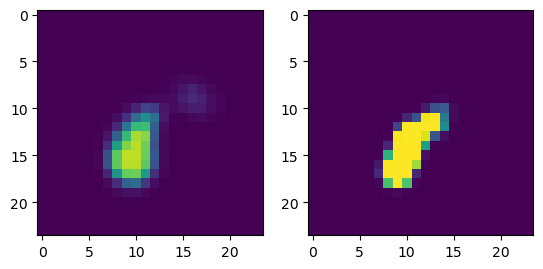

In [ ]:
rep, pharm = get_mol_voxels("OC(C=C1)=C(CN2CCCC2)C=C1NC3=CC=NC4=CC=CC=C43")

noise = torch.randn(1,5,24,24,24)
noisy_rep = ddpm.add_noise(rep.reshape(-1,5,24,24,24),noise, torch.tensor([999]))
out = net(noisy_rep.cuda(),pharm.reshape(-1,3,24,24,24).cuda()).cpu().detach().numpy()
# out = net(noise.cuda(),pharm.reshape(-1,3,24,24,24).cuda()).cpu().detach().numpy()


fig, axs = plt.subplots(1,2)
axs[0].imshow(out[0][4][14], vmin=0,vmax=1)
axs[1].imshow(rep[4][14], vmin=0, vmax=1)

## Timestep and Pharmacophore Conditioning

In [5]:
from networks import UNet3D_ptcond

net = UNet3D_ptcond(in_channels=5, num_classes=5)
net.to(device)

# net.load_state_dict(torch.load("../models/state_dict_net_ptcond.pt"))

UNet3D_ptcond(
  (embed_timesteps): Embedding(1000, 5)
  (embed_pharm): Sequential(
    (0): Conv3d(3, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Linear(in_features=24, out_features=24, bias=True)
  )
  (a_block1): Conv3DBlock(
    (conv1): Conv3d(11, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (a_block2): Conv3DBlock(
    (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 128, kernel_size=(

In [6]:
# How many runs through the data should we do?
n_epochs = 1

train_dataloader = DataLoader(smile_DS, batch_size=32, collate_fn=collate_batch)

# Our loss finction
loss_fn = nn.BCELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=0.001) 

# Keeping a record of the losses for later viewing
losses_net = []
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

In [8]:
for epoch in range(n_epochs):
    
    for i, (x, targets) in enumerate(train_dataloader):
        timesteps = torch.randint(
            0,
            ddpm.num_train_timesteps,
            (x.shape[0],),
            device=x.device,
        ).long()

        noise = torch.randn(x.shape).to(x.device)
        noisy_x = ddpm.add_noise(x, noise, timesteps)


        noisy_x = noisy_x.type(torch.FloatTensor).to(device)

        x = x.to(device) # Data on the GPU
        # Get the model prediction

        pred = net(noisy_x, timesteps.to(device), targets.to(device))

        # Calculate the loss
        
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        losses_net.append(loss.cpu().detach().numpy())

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()


        if (i+1)%10 == 0:
            print(loss)
        if (i+1)%500 == 0:
            torch.save(net.state_dict(), "../models/state_dict_net_pcond.pt")
            print("500 batches done")


    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses_net[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses_net)

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0738, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0538, devic

[13:11:35] UFFTYPER: Unrecognized atom type: S_5+4 (1)


tensor(0.0122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
500 batches done
tensor(0.0108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
ten

KeyboardInterrupt: 

In [134]:
timesteps

tensor([790, 676, 241, 874, 678,  59, 263, 227, 795, 421, 912, 992, 418, 724,
        544,  95, 586, 869, 922, 642, 410, 420, 569, 956, 499, 577, 522, 750,
        199, 916, 413, 766])

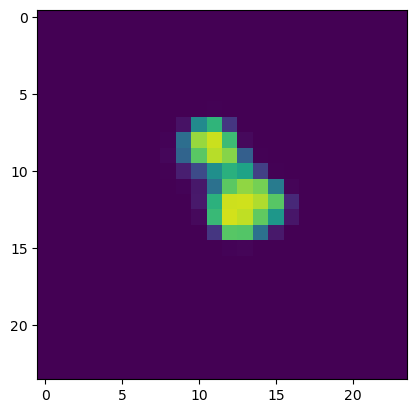

: 

In [143]:
plt.imshow(pred[np.argmin(timesteps)][2][15].cpu().detach().numpy(), vmin=0, vmax=1)

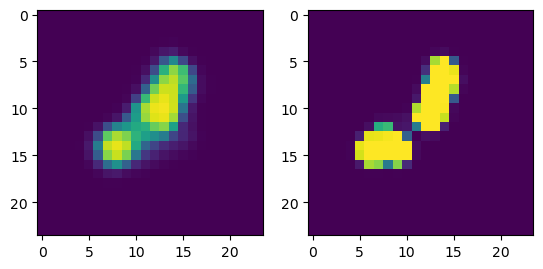

In [128]:
# x = torch.randn(64,5,24,24,24).to(device)
# rep, pharm = get_mol_voxels("OC(C=C1)=C(CN2CCCC2)C=C1NC3=CC=NC4=CC=CC=C43")
# pharm = pharm.reshape(-1,3,24,24,24)
# # pharm = torch.randn(1,3,24,24,24)
# pharm = torch.cat([pharm]*x.shape[0])

# ddpm.set_timesteps(50)

# # Sampling loop
# for i, t in enumerate(ddpm.timesteps):

#     # Get model pred
#     with torch.no_grad():
#         residual = net(x, torch.cat([t.expand(1)]*x.shape[0]).to(device), pharm.to(device))  # Again, note that we pass in our labels y

#     # Update sample with step
#     x = ddpm.step(residual, t, x).prev_sample

# # Show the results
# out = residual.cpu().detach().numpy()

chan = 4
layer = 13
fig, axs = plt.subplots(1,2)
axs[0].imshow(out[23][chan][layer], vmin=0,vmax=1)
axs[1].imshow(rep[chan][layer], vmin=0, vmax=1)

In [5]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
from diffusers import DDPMScheduler
import os
import sys
sys.path.insert(1,"../scripts")
from get_voxels import collate_batch
from networks import EncoderCNN, DecoderRNN, UNet3D_tcond, Encoder


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

if "models" not in os.listdir("../"):
    os.mkdir("../models")
out_dir = "../models/"

if "reports" not in os.listdir("../"):
    os.mkdir("../reports")

log_file = open(os.path.join("../reports/log.txt"), "w")

smiles = []
with open("../datasets/raw/zinc15_druglike_clean_canonical_max60.smi") as f:
    i=0
    for i, line in enumerate(f):
        smiles.append(line[:-1])
        if i > 5000000:
            break

class CustomImageDataset(Dataset):
    def __init__(self, smiles):
        self.smiles = smiles

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smile = self.smiles[idx]
        return smile

smile_DS = CustomImageDataset(smiles)

# Define the networks
encoderCNN = EncoderCNN(5)
decoderRNN = DecoderRNN(512, 1024, 29, 1)
encoder = Encoder()
net = UNet3D_tcond(5,5)
encoderCNN.to(device)
decoderRNN.to(device)
net.to(device)
encoder.to(device)

#Encoder Optimizer
criterionEncoder = nn.BCELoss()
#Encoder optimizer
optimizerEncoder = torch.optim.Adam(encoder.parameters(), lr = 0.001)

# Our loss finction
criterionNet = nn.BCELoss()
# The optimizer
optimizerNet = torch.optim.Adam(net.parameters(), lr=0.001) 

# Caption optimizer
criterionCaption = nn.CrossEntropyLoss()
caption_params = list(decoderRNN.parameters()) + list(encoderCNN.parameters())
caption_optimizer = torch.optim.Adam(caption_params, lr=0.001)

#Other training stuff
train_dataloader = DataLoader(smile_DS, batch_size=16, collate_fn=collate_batch)
scheduler = DDPMScheduler(num_train_timesteps=1000)

for i, (x, captions, pharm, lengths) in enumerate(train_dataloader):

    #Train Encoder and Unet
    ##Unet
    timesteps = torch.randint(
        0,
        scheduler.num_train_timesteps,
        (x.shape[0],),
        device=x.device,
    ).long()

    noise = torch.randn(x.shape).to(x.device)
    noisy_x = scheduler.add_noise(x, noise, timesteps)    
    noisy_x = noisy_x.type(torch.FloatTensor).to(device)
    x = x.to(device)
    pred = net(noisy_x, timesteps.to(device))
    net_loss = criterionNet(pred, x)
    optimizerNet.zero_grad()
    net_loss.backward()
    optimizerNet.step()
    net_loss = net_loss.cpu()

    ##Encoder
    pharm = pharm.to(device)
    # Forward pass
    encoded_tensor = encoder(x)
    enc_loss=criterionEncoder(encoded_tensor, pharm)
    # Backward and optimize
    optimizerEncoder.zero_grad()
    enc_loss.backward()
    optimizerEncoder.step()

    ##Train Captioning Networks after ~6000 batches compounds 
    if i > 6000:
        captions = Variable(captions.to(device))
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        decoderRNN.zero_grad()
        encoderCNN.zero_grad()
        features = encoderCNN(pred.detach())
        outputs = decoderRNN(features, captions, lengths)
        cap_loss = criterionCaption(outputs, targets)
        cap_loss.backward()
        caption_optimizer.step()

    if (i+1)%60000 == 0:
        log_file.write("reducing learning rate/n")
        log_file.flush()        
        for param_group in caption_optimizer.param_groups:
            lr = param_group["lr"] / 2.
            param_group["lr"] = lr

    if (i + 1) % 500 == 0:
        if (i+1)%1000 == 0:
            torch.save(net.state_dict(),"../models/net_weights_{}.pkl".format(i+1))
            torch.save(encoder.state_dict(),"../models/net_weights_{}.pkl".format(i+1))
            torch.save(encoderCNN.state_dict(),"../models/net_weights_{}.pkl".format(i+1))
            torch.save(decoderRNN.state_dict(),"../models/net_weights_{}.pkl".format(i+1))
        if i > 6000:
            log_file.write("Batch: {}\nNet Loss: {}\nEncoder Loss: {}\nCaptioning Loss: {}.\n".format((i+1),net_loss,enc_loss,cap_loss))
            log_file.flush()
        else:
            log_file.write("Batch: {}\nNet Loss: {}\nEncoder Loss: {}.\n\n".format((i+1),net_loss,enc_loss))
            log_file.flush()

    if i == 39060:
        # We are Done!
        log_file.close()
        break

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Batch 10 of 312501.
Batch 20 of 312501.
Batch 30 of 312501.
Batch 40 of 312501.
Batch 50 of 312501.
Batch 60 of 312501.
Batch 70 of 312501.
Batch 80 of 312501.
Batch 90 of 312501.
Batch 100 of 312501.
Batch 110 of 312501.
Batch 120 of 312501.


KeyboardInterrupt: 